# Predict students' dropout and academic success

## Data Description

* `Marital status` - The marital status of the student. (Categorical)
* `Application mode` - The method of application used by the student. (Categorical)
* `Application order`	- The order in which the student applied. (Numerical)
* `Course` - The course taken by the student. (Categorical)
* `Daytime/evening attendance` - Whether the student attends classes during the day or in the evening. (Categorical)
* `Previous qualification` - The qualification obtained by the student before enrolling in higher education. (Categorical)
* `Nacionality` - The nationality of the student. (Categorical)
* `Mother's qualification` - The qualification of the student's mother. (Categorical)
* `Father's qualification` - The qualification of the student's father. (Categorical)
* `Mother's occupation` - The occupation of the student's mother. (Categorical)
* `Father's occupation` - The occupation of the student's father. (Categorical)
* `Displaced` - Whether the student is a displaced person. (Categorical)
* `Educational special needs` - Whether the student has any special educational needs. (Categorical)
* `Debtor` - Whether the student is a debtor. (Categorical)
* `Tuition fees up to date` - Whether the student's tuition fees are up to date. (Categorical)
* `Gender` - The gender of the student. (Categorical)
* `Scholarship holder` - Whether the student is a scholarship holder. (Categorical)
* `Age at enrollment` - The age of the student at the time of enrollment. (Numerical)
* `International`	Whether the student is an international student. (Categorical)
* `Curricular units 1st sem (credited)` - The number of curricular units credited by the student in the first semester. (Numerical)
* `Curricular units 1st sem (enrolled)` - The number of curricular units enrolled by the student in the first semester. (Numerical)
* `Curricular units 1st sem (evaluations)` - The number of curricular units evaluated by the student in the first semester. (Numerical)
* `Curricular units 1st sem (approved)` - The number of curricular units approved by the student in the first semester. (Numerical)

In [1]:
# imoport 
import pandas as pd
import numpy as np
import scipy.stats as stats
import pickle
import optuna
import matplotlib.pyplot as plt

from optuna.samplers import TPESampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, ConfusionMatrixDisplay
from catboost import CatBoostClassifier

In [2]:
data = pd.read_csv('dataset.csv')
pd.set_option('display.max_columns', None)

In [3]:
data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,10,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,4,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,10,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,4,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,10,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [4]:
def data_info(data):
    return print(f'Number of duplicates: {data.duplicated().sum()}', f'Gaps in data: {data.isna().sum().sum()}', f'Data info: {data.info()}', sep='\n')

data_info(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

In [5]:
# numerical and categorical features
columns_categorical = data.drop(['Application order', 'Age at enrollment', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 
                                 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 
                                 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 
                                 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 
                                 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP'], axis=1).columns

columns_numerical = ['Application mode', 'Age at enrollment', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 
                                 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 
                                 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 
                                 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 
                                 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP']

In [6]:
data[columns_categorical].corr(method='spearman').style.background_gradient(cmap='bwr')

,Marital status,Application mode,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,International
Marital status,1.000000,0.270338,0.031889,-0.357320,0.188576,-0.029930,0.192536,0.122113,0.121093,0.058346,-0.275918,-0.032252,0.033400,-0.092234,0.014188,-0.095139,-0.030175
Application mode,0.270338,1.000000,-0.087354,-0.268726,0.423540,0.003433,0.069391,0.045777,0.030603,-0.016551,-0.266543,-0.032189,0.112283,-0.128854,0.148044,-0.158408,0.003683
Course,0.031889,-0.087354,1.000000,-0.087342,-0.144830,-0.004301,0.052636,0.035973,0.036599,0.022852,0.008664,-0.001114,-0.054098,0.030614,-0.112818,0.053685,-0.004209
Daytime/evening attendance,-0.357320,-0.268726,-0.087342,1.000000,-0.136938,0.027889,-0.163797,-0.093102,-0.073108,-0.031016,0.251767,0.031017,0.006658,0.038799,-0.012326,0.093912,0.027973
Previous qualification,0.188576,0.423540,-0.144830,-0.136938,1.000000,-0.041196,0.026148,0.014766,-0.009784,-0.002623,-0.186108,-0.022698,0.106365,-0.116064,0.082618,-0.119596,-0.040939
Nacionality,-0.029930,0.003433,-0.004301,0.027889,-0.041196,1.000000,-0.035231,-0.084564,0.032168,0.017052,-0.009827,-0.003676,0.075358,-0.044132,-0.026450,-0.027660,0.999899
Mother's qualification,0.192536,0.069391,0.052636,-0.163797,0.026148,-0.035231,1.000000,0.434072,0.351873,0.163485,-0.060943,-0.016539,0.012572,-0.011134,-0.060032,0.038777,-0.034822
Father's qualification,0.122113,0.045777,0.035973,-0.093102,0.014766,-0.084564,0.434072,1.000000,0.252229,0.244216,-0.037829,0.004045,-0.002742,-0.002422,-0.071540,0.109689,-0.084165
Mother's occupation,0.121093,0.030603,0.036599,-0.073108,-0.009784,0.032168,0.351873,0.252229,1.000000,0.479459,-0.036242,-0.015875,0.080032,-0.030134,-0.023220,0.134402,0.031790
Father's occupation,0.058346,-0.016551,0.022852,-0.031016,-0.002623,0.017052,0.163485,0.244216,0.479459,1.000000,-0.022054,-0.005602,0.035800,-0.007955,-0.030904,0.096972,0.016956


In [7]:
data[columns_numerical].corr(method='spearman').style.background_gradient(cmap='bwr')

,Application mode,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
Application mode,1.000000,0.542502,0.351321,0.066196,0.198720,-0.079889,-0.154711,0.029345,0.343836,0.045705,0.149757,-0.104197,-0.139767,0.050885,0.090526,-0.025531,-0.021415
Age at enrollment,0.542502,1.000000,0.298854,0.000804,0.170565,-0.165780,-0.209916,0.060934,0.300595,-0.031458,0.082710,-0.187984,-0.213470,0.094494,0.018600,0.018181,-0.056524
Curricular units 1st sem (credited),0.351321,0.298854,1.000000,0.423096,0.366472,0.361512,0.100758,0.100024,0.914262,0.376104,0.330536,0.288796,0.093474,0.063940,0.024184,-0.001823,0.021784
Curricular units 1st sem (enrolled),0.066196,0.000804,0.423096,1.000000,0.420242,0.706555,0.363198,-0.018757,0.440119,0.961826,0.431285,0.653198,0.351465,-0.020600,0.108336,0.016873,0.017965
Curricular units 1st sem (evaluations),0.198720,0.170565,0.366472,0.420242,1.000000,0.262063,0.111945,0.202056,0.369342,0.385720,0.693603,0.251594,0.090177,0.152757,0.067037,-0.039721,-0.096700
Curricular units 1st sem (approved),-0.079889,-0.165780,0.361512,0.706555,0.262063,1.000000,0.639785,-0.068897,0.366941,0.699429,0.364337,0.891679,0.662825,-0.073444,0.074288,-0.002490,0.059292
Curricular units 1st sem (grade),-0.154711,-0.209916,0.100758,0.363198,0.111945,0.639785,1.000000,-0.016930,0.096860,0.368004,0.181924,0.628588,0.762356,-0.046669,0.045004,-0.037431,0.091843
Curricular units 1st sem (without evaluations),0.029345,0.060934,0.100024,-0.018757,0.202056,-0.068897,-0.016930,1.000000,0.058695,-0.032372,0.096252,-0.054598,-0.040764,0.383552,-0.066878,-0.067866,-0.183582
Curricular units 2nd sem (credited),0.343836,0.300595,0.914262,0.440119,0.369342,0.366941,0.096860,0.058695,1.000000,0.413560,0.342310,0.319168,0.103379,0.082372,0.012190,-0.000530,0.023758
Curricular units 2nd sem (enrolled),0.045705,-0.031458,0.376104,0.961826,0.385720,0.699429,0.368004,-0.032372,0.413560,1.000000,0.439891,0.674169,0.364401,-0.027430,0.138861,0.008952,0.018671


Internationality and nationality multicollinear features. 

In [8]:
# drop International
#data=data.drop(['International', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)',
#                'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 1st sem (approved)'], axis=1)

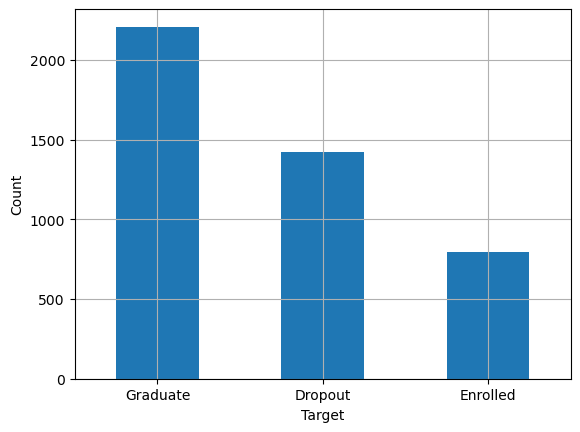

In [9]:
data.Target.value_counts().plot(kind='bar', grid=True, rot=0, ylabel='Count', xlabel='Target');

### Features and target

In [10]:
X = data.drop('Target', axis=1)
y=data.Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [11]:
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

### CatBoost with Optuna

In [15]:
def objective(trial):
    params={
        'iterations': trial.suggest_int("iterations", 100, 1000),
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'depth': trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        'bootstrap_type': trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        'random_strength': trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        'od_type': trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        'od_wait': trial.suggest_int("od_wait", 10, 50)
    }
    
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    
    model_cat = CatBoostClassifier(**params, verbose=False)
    model_cat.fit(X_train, y_train)
    y_pred = model_cat.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [16]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=200)

In [17]:
study.best_params

{'iterations': 658,
 'learning_rate': 0.025849608730961218,
 'depth': 4,
 'l2_leaf_reg': 9.240788820586247e-08,
 'bootstrap_type': 'Bernoulli',
 'random_strength': 1.0817729608361354e-06,
 'od_type': 'Iter',
 'od_wait': 32,
 'subsample': 0.7611378459246193}

In [18]:
study.best_value

0.8146473779385172

In [19]:
model_cat = CatBoostClassifier(**study.best_params, verbose=False)
model_cat.fit(X_train, y_train)
y_pred = model_cat.predict(X_test)

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       353
           1       0.68      0.47      0.55       193
           2       0.83      0.95      0.88       560

    accuracy                           0.81      1106
   macro avg       0.78      0.74      0.75      1106
weighted avg       0.81      0.81      0.80      1106



In [ ]:
with open('model_cat.pickle', 'wb') as file:
    pickle.dump(model_cat, file)

In [ ]:
y_pred

array([[2],
       [0],
       [2],
       ...,
       [0],
       [2],
       [2]], dtype=int64)

In [ ]:
y_test

array([2, 0, 2, ..., 1, 2, 2])

In [21]:
# confusion_matrix for optuna
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[281,  30,  42],
       [ 37,  90,  66],
       [ 18,  12, 530]], dtype=int64)